## Generate stamps with adequate SNR distribution 
### (assumes SNR>SNRmin and Euclidean counts; input for ResNet example) 

<a id='toc'></a>


[Go to the start of sample generation](#sample) 
 
 
#### This notebook was developed by [Zeljko Ivezic](http://faculty.washington.edu/ivezic/) for the 2021 data science class at the University of Sao Paulo and it is available from [github](https://github.com/ivezic/SaoPaulo2021/blob/main/notebooks/makeSampleResNet.ipynb).

In [1]:
%matplotlib inline

import os
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats.distributions import rv_continuous

from astropy.io import fits 

plt.rc("lines", linewidth=1)
plt.rc("figure", dpi=170) 

In [2]:
# "stolen" from astroML  (file $(astroMLdir)/astroML/stats/random.py)
#----------------------------------------------------------------------
# Define some new distributions based on rv_continuous
class trunc_exp_gen(rv_continuous):
    """A truncated positive exponential continuous random variable.

    The probability distribution is::

       p(x) ~ exp(k * x)   between a and b
            = 0            otherwise

    The arguments are (a, b, k)

    %(before_notes)s

    %(example)s

    """
    def _argcheck(self, a, b, k):
        self._const = k / (np.exp(k * b) - np.exp(k * a))
        return (a != b) and not np.isinf(k)

    def _pdf(self, x, a, b, k):
        pdf = self._const * np.exp(k * x)
        pdf[(x < a) | (x > b)] = 0
        return pdf

    def _rvs(self, a, b, k):
        y = np.random.random(self._size)
        return (1. / k) * np.log(1 + y * k / self._const)

trunc_exp = trunc_exp_gen(name="trunc_exp", shapes='a, b, k')

In [3]:
def showStamp(image):
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(np.flipud(image), vmin=np.min(image), vmax=1.05*np.max(image))
    return

# given stamp data, return stamp (image)
def getStamp(oneDpixels, sD):
    # make noiseless image size given by 1Dpixels)
    nonoise = gauss2Delliptical(sD['muX'], sD['muY'], sD['sig1'], sD['sig2'], sD['alphaDeg'], \
                 sD['Counts'], sD['background'], oneDpixels[:, np.newaxis], oneDpixels)
    # now add noise (do NOT include source noise - only the background noise!)
    image = addnoise(nonoise, sD['sigNoise']) 
    return image

def addnoise(inimage, sigNoise, addsourcenoise=0):
    # make a copy of input image and add gaussian noise
    image = np.copy(inimage)
    image += np.random.normal(0, sigNoise, image.shape)
    if (addsourcenoise):
        gain = 1.0
        image += np.random.normal(0, np.sqrt(inimage / gain), image.shape)
    return image

def gauss2Delliptical(muX, muY, sig1, sig2, alpha, A, B, Xpixels, Ypixels):
    """2D elliptical gaussian + background"""
    # alpha is in degree and note the minus sign below (to go E from N) 
    cosSq = np.cos(-alpha/180*np.pi)**2
    sinSq = np.sin(-alpha/180*np.pi)**2
    sigX = np.sqrt(sig1**2*cosSq + sig2**2*sinSq)
    sigY = np.sqrt(sig1**2*sinSq + sig2**2*cosSq)
    sigXY = (sig1**2 - sig2**2) * np.sin(-alpha/180*np.pi) * np.cos(-alpha/180*np.pi) 
    rho = sigXY/sigX/sigY
    zSquare = (Xpixels - muX)**2/sigX**2 + (Ypixels - muY)**2/sigY**2 \
                  - 2*rho*(Xpixels - muX)*(Ypixels - muY)/sigX/sigY
    # make and set image to the background value
    image = np.empty(zSquare.shape)
    image.fill(B)
    # now add elliptical gaussian profile (area is normalized to A)
    image += A * np.exp(-zSquare / 2/(1-rho**2)) / (2 * math.pi * sig1 * sig2)
    return image 


def measureStamp(stamp, psf, oneDpix, stampData):
    # first psf flux
    psfN = psf/np.sum(psf)
    weight = psfN/np.sum(psfN**2)
    stampData['CountsMeasured'] = np.sum(weight*stamp) 
    stampData['CountsMeasuredErr'] = stampData['sigNoise']/np.sqrt(np.sum(psfN**2))
    stampData['SNR'] = stampData['CountsMeasured']/stampData['CountsMeasuredErr']  
    # and now 2nd moments
    x2D = 0*oneDpix[:, np.newaxis] + oneDpix
    y2D = oneDpix[:, np.newaxis] + 0*oneDpix
    # should be measured centroids... 
    xoff = x2D - stampData['muX']
    yoff = y2D - stampData['muY']
    roffSq = xoff**2 + yoff**2
    stampData['sigxxMeasured'] = np.sum(weight*xoff**2*stamp)/np.sum(weight*stamp)
    stampData['sigxyMeasured'] = np.sum(weight*xoff*yoff*stamp)/np.sum(weight*stamp)
    stampData['sigyyMeasured'] = np.sum(weight*yoff**2*stamp)/np.sum(weight*stamp)
    sXX = stampData['sigxxMeasured'] 
    sXY = stampData['sigxyMeasured'] 
    sYY = stampData['sigyyMeasured'] 
    aux1 = (sXX**2+sYY**2)/2
    aux2 = np.sqrt((sXX**2-sYY**2)**2/4+sXY**2)
    stampData['sigP1Measured'] = aux1 + aux2
    stampData['sigP2Measured'] = aux1 - aux2
    stampData['angleDegMeasured'] = 90/np.pi*np.arctan(2*sXY/(sXX**2-sYY**2))
    return


def makePSFstamp(displayStamp=False):
    ## THIS IS WHERE STAMP SIZE IS DEFINED
    oneDpixels = np.linspace(-15.5, 15.5, 32)  
    stampData = {"author": 'Zeljko Ivezic'}
    stampData['muX'] = 0
    stampData['muY'] = 0
    # sigma values are in pixels (LSST: 1 pix=0.2 arcsec)
    # for Gaussian FWHM = 2.355 * sig
    # so for LSST's FWHM=0.8" we get sig2 = 1.7 pixels
    # first PSF 
    stampData['sig2'] = 1.7
    stampData['sig1'] = stampData['sig2'] 
    stampData['alphaDeg'] = 0.0
    stampData['sigNoise'] = 0.0
    stampData['background'] = 0 
    stampData['Counts'] = 1000
    psf = getStamp(oneDpixels, stampData)
    measureStamp(psf, psf, oneDpixels, stampData)
    if displayStamp:
        showStamp(psf) 
    stampData['type'] = 'psf'
    return psf, oneDpixels, stampData


def makeStar(psf, counts, SNR, oneDpixels, displayStamp=False):
    stampData = {"author": 'Zeljko Ivezic'}
    stampData['muX'] = 0
    stampData['muY'] = 0
    # sigma values are in pixels (LSST: 1 pix=0.2 arcsec)
    # for Gaussian FWHM = 2.355 * sig
    # so for LSST's FWHM=0.8" we get sig2 = 1.7 pixels
    stampData['sig2'] = 1.7
    stampData['sig1'] = stampData['sig2'] 
    stampData['alphaDeg'] = 0.0
    # this noise value gives SNR=5 for PSF flux and Counts=1000 
    stampData['sigNoise'] = 33.0*5/SNR
    stampData['background'] = 0 
    stampData['Counts'] = counts
    star = getStamp(oneDpixels, stampData)
    measureStamp(star, psf, oneDpixels, stampData)
    if displayStamp:
        showStamp(star)
    stampData['type'] = 'star'
    return star, stampData


def makeTrail(psf, counts, SNR, oneDpixels, alphaDeg, axisRatio, displayStamp=False):
    stampData = {"author": 'Zeljko Ivezic'}
    stampData['muX'] = 0
    stampData['muY'] = 0
    # sigma values are in pixels (LSST: 1 pix=0.2 arcsec)
    # for Gaussian FWHM = 2.355 * sig
    # so for LSST's FWHM=0.8" we get sig2 = 1.7 pixels
    stampData['sig2'] = 1.7
    # for v = 0.64 deg/day, motion is 0.8", so ellipticity ~ 2
    stampData['sig1'] = axisRatio * stampData['sig2'] 
    stampData['alphaDeg'] = alphaDeg
    # this noise value gives SNR=5 for PSF flux and Counts=1000 
    stampData['sigNoise'] = 33.0*5/SNR
    stampData['background'] = 0 
    stampData['Counts'] = counts
    trail = getStamp(oneDpixels, stampData)
    measureStamp(trail, psf, oneDpixels, stampData)
    if displayStamp:
        showStamp(trail) 
    stampData['type'] = 'trail'
    return trail, stampData


def makeDipole(psf, counts, SNR, oneDpixels, muX, muY, displayStamp=False):
    star, stampData = makeStar(psf, counts, SNR, oneDpixels, displayStamp)
    stampData['muX'] = muX
    stampData['muY'] = muY
    star2 = getStamp(oneDpixels, stampData)
    dipole = star - star2   
    measureStamp(dipole, psf, oneDpixels, stampData)
    if displayStamp:
        showStamp(dipole) 
    stampData['type'] = 'dipole'
    return dipole, stampData


def saveStamp(stamp, filename, hdrData="", writePixels=True):
    if writePixels:
        hdu = fits.PrimaryHDU(stamp)
    else:
        hdu = fits.PrimaryHDU()
    hdr = hdu.header
    if hdrData!="":
        for entry in hdrData:
            hdr[entry] = hdrData[entry]
    # print('saveStamp: writing to', filename)
    hdu.writeto(filename)
    return 

def saveStampNPY(counter, nPix, npyArray, stamp, filename, hdrData=""):    
    npyArray[counter,0:nPix,0:nPix,0] = stamp
    saveStamp("", filename, hdrData=hdrData, writePixels=False)
    return 
    
def getSNR(N, SNRmin, k=0.6):
    # return an array of N values of SNR generated from a distribution 
    # that follows exponential counts: logN(mag) = C + k*mag
    # in the range SNR>SNRmin 
    # for k=0.6 we have the so-called Euclidean counts
    # astroML code for truncated exponential distribution of mags: 
    mMax = 24-16 # LSST limits: from 5-sigma to saturation
    # that is, SNRmax = SNRmin * 10**(0.4*(mMax)) if k=0.6
    true_dist = trunc_exp(0, mMax, k * np.log(10))
    # draw and return 
    np.random.seed(0)
    mag = true_dist.rvs(N)
    # and now transform to SNR, assuming mMax is 5-sigma 
    SNR = SNRmin * 10**(0.4*(mMax-mag))
    return SNR

def makeStars(psf, oneDpixels, istart, Nstamp, fileroot, SNRmin=50, FITS=False, npyArray=""):
    counts = 1000
    # generate SNR 
    SNR = getSNR(Nstamp, SNRmin)
    for i in range(istart, istart+Nstamp):
        star, starData = makeStar(psf, counts, SNR[i-istart], oneDpixels, False)
        starData['ID'] = i
        filename = fileroot + str(i) + '.fits'
        # print('writing:', filename)
        if (npyArray==""):
            if FITS: saveStamp(star, filename, hdrData=starData)
        else:
            saveStampNPY(i, oneDpixels.size, npyArray, star, filename, hdrData=starData)
    return istart+Nstamp

def makeTrails(psf, oneDpixels, istart, Nstamp, fileroot, SNRmin=50, FITS=False, npyArray=""):
    counts = 1000
    # generate SNR 
    SNR = getSNR(Nstamp, SNRmin)
    for i in range(istart, istart+Nstamp):
        # generate axis ratio (uniform in the range 1.1-2)
        axisRatio = 1.1 + np.random.random()
        # orientation is random in the range 0-180 deg
        alphaDeg = 180*np.random.random()
        trail, trailData = makeTrail(psf, counts, SNR[i-istart], oneDpixels, alphaDeg, axisRatio, False)
        trailData['ID'] = i
        filename = fileroot + str(i) + '.fits'
        if (npyArray==""):
            if FITS: saveStamp(trail, filename, hdrData=trailData)
        else:
            saveStampNPY(i, oneDpixels.size, npyArray, trail, filename, hdrData=trailData)
    return istart+Nstamp

def makeDipoles(psf, oneDpixels, istart, Nstamp, fileroot, SNRmin=50, FITS=False, npyArray=""):
    counts = 1000
    # generate SNR 
    SNR = getSNR(Nstamp, SNRmin)
    for i in range(istart, istart+Nstamp):
        # centroid pixel offsets in the range -0.5 to 0.5  
        muX = -0.5+np.random.random()
        muY = 0.5-np.random.random()
        # generate SNR and muX/muY
        dipole, dipoleData = makeDipole(psf, counts, SNR[i-istart], oneDpixels, muX, muY, False) 
        dipoleData['ID'] = i
        filename = fileroot + str(i) + '.fits'
        if (npyArray==""):
            if FITS: saveStamp(dipole, filename, hdrData=dipoleData)
        else:
            saveStampNPY(i, oneDpixels.size, npyArray, dipole, filename, hdrData=dipoleData)
    return istart+Nstamp

In [4]:
def getStampData(fileroot, N1, N2):
    Nstamps = N2-N1+1
    trueE = np.zeros(Nstamps)
    measuredE = np.zeros(Nstamps)
    SNR = np.zeros(Nstamps) 
    aD = np.zeros(Nstamps) 
    aM = np.zeros(Nstamps) 
    CountsM = np.zeros(Nstamps) 
    sigP1 = np.zeros(Nstamps) 
    labels = []
    for i in range(0, Nstamps):
        filename = fileroot + str(i) + '.fits'
        s = fits.open(filename)
        trueE[i] = s[0].header['sig1']/s[0].header['sig2']
        measuredE[i] = s[0].header['sigP1Measured']/s[0].header['sigP2Measured']
        labels.append(s[0].header['type'])
        SNR[i] = s[0].header['SNR']
        aD[i] = s[0].header['alphaDeg']
        aM[i] = s[0].header['angleDegMeasured']
        CountsM[i] = s[0].header['CountsMeasured']
        sigP1[i] = s[0].header['sigP1Measured']
    return np.array(labels), SNR, CountsM, trueE, measuredE, sigP1, aD, aM

def plotEllipticity(labels, SNR, trueE, measuredE):
    # plot mE vs. tE, and tE/mE vs. SNR, color-coded by labels 
    return 

In [5]:
# from LSST_project/utils/statistics_2d.py
def calculate_mean(image, mask=None):
    if mask is not None:
        image = image[mask != 0]

    pixels = np.reshape(image, (-1,))

    return np.sum(pixels) / len(pixels)


def calculate_standard_deviation(image, mean=None, mask=None):
    if mean is None:
        mean = calculate_mean(image, mask)

    if mask is not None:
        image = image[mask != 0]

    pixels = np.reshape(image, (-1,))
    return np.sqrt(np.sum(np.square(pixels - mean)) / (len(pixels) - 1))


def calculate_median(image, mask=None):
    if mask is not None:
        image = image[mask != 0]
    return np.median(np.reshape(image, (-1,)))


def calculate_sigma_g(image, mask=None):
    image = image[mask != 0]
    image = np.reshape(image, (-1,))
    quantile_25 = np.quantile(image, 0.25)
    quantile_75 = np.quantile(image, 0.75)
    return 0.7413 * (quantile_75 - quantile_25)

def calculate_deviation_from_normal_distribution(image, mean=None, std=None,
                                                 median=None, sigma_g=None,
                                                 mask=None):
    if mean is None:
        mean = calculate_mean(image, mask)

    if std is None:
        std = calculate_standard_deviation(image, mean, mask)

    if median is None:
        median = calculate_median(image, mask)

    if sigma_g is None:
        sigma_g = calculate_sigma_g(image, mask)

    dm = mean - median

    sr = sigma_g / std if std != 0 else 0

    return dm, sr

In [6]:
def showStamp(image):
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(np.flipud(image), vmin=np.min(image), vmax=1.05*np.max(image))
    return

def getSigmaInCircle(image, rPixSq, circRadius):
    # get the mean and standard deviation for all pixels outside a circle
    # centered in the middle of the image and diameter equal to image size
    if circRadius > 0:
        m = np.where(rPixSq<circRadius**2, 1, 0)
    else:
        m = np.where(rPixSq>circRadius**2, 1, 0)
    showStamp(m)
    print(calculate_median(image, m), calculate_sigma_g(image, m))
    
def getChi2InCircle(data, model, sigma, rPixSq, circRadius):
    # compute chi2 per degree of freedom for Npix pixels with rPixSq < circRadius**2  
    # chi2 = sum[(data-model)^2/variance]/Npix,
    # TESTING MODE: if circRadius<0, use pixels with rPixSq > circRadius**2 
    if circRadius > 0:
        m = np.where(rPixSq<circRadius**2, 1, 0)
    else:
        m = np.where(rPixSq>circRadius**2, 1, 0)
    Npix = np.sum(m)
    chi = (data-model)/sigma
    return Npix, calculate_median(chi, m), calculate_sigma_g(chi, m) 

def getCountsInCircle(data, rPixSq, circRadius):
    # compute chi2 per degree of freedom for Npix pixels with rPixSq < circRadius**2  
    # chi2 = sum[(data-model)^2/variance]/Npix,
    # TESTING MODE: if circRadius<0, use pixels with rPixSq > circRadius**2 
    if circRadius > 0:
        m = np.where(rPixSq<circRadius**2, 1, 0)
    else:
        m = np.where(rPixSq>circRadius**2, 1, 0)
    Npix = np.sum(m)
    return Npix, Npix*calculate_mean(data, m)

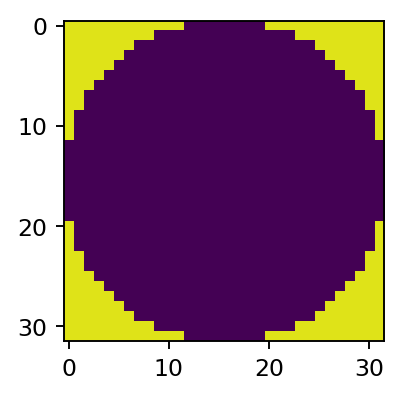

In [7]:
# a hack to make geometric mask for estimating background noise
Npix = 32
oneDpix = np.linspace(-(Npix-1)/2, (Npix-1)/2, 32)  
x2D = 0*oneDpix[:, np.newaxis] + oneDpix 
y2D = oneDpix[:, np.newaxis] + 0*oneDpix 
rPixSq = x2D**2 + y2D**2  
maskBkgd = np.where(rPixSq>16**2, 1, 0)
showStamp(maskBkgd)

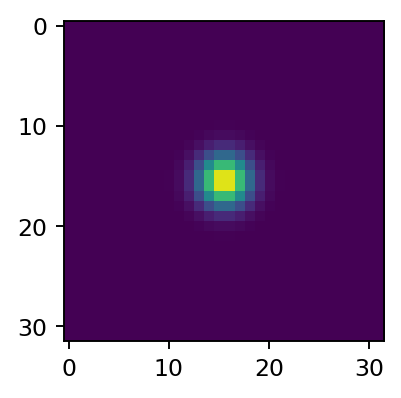

In [8]:
psf, oneDpixels, psfData = makePSFstamp(True)

In [9]:
psfData

{'author': 'Zeljko Ivezic',
 'muX': 0,
 'muY': 0,
 'sig2': 1.7,
 'sig1': 1.7,
 'alphaDeg': 0.0,
 'sigNoise': 0.0,
 'background': 0,
 'Counts': 1000,
 'CountsMeasured': 999.9999999999997,
 'CountsMeasuredErr': 0.0,
 'SNR': inf,
 'sigxxMeasured': 1.4450000000675578,
 'sigxyMeasured': 2.2204460492503136e-19,
 'sigyyMeasured': 1.4450000000675578,
 'sigP1Measured': 2.088025000195242,
 'sigP2Measured': 2.088025000195242,
 'angleDegMeasured': 45.0,
 'type': 'psf'}

In [10]:
def getChi2Stats(image, maskBkgd, rPixSq):
    # showStamp(image)
    # get background level and noise 
    medBkgd = calculate_median(image, maskBkgd)
    sigBkgd = calculate_sigma_g(image, maskBkgd)
    # model assumes background without a source: can we "see" that 
    # there is a source through metricChi2=(chi2-1)/sigChi2? 
    model = 0*image
    Npix, medianChi, chi2 = getChi2InCircle(image, model, sigBkgd, rPixSq, 2.7)
    metricChi2 = (chi2-1)/np.sqrt(2/Npix)
    print(Npix, medBkgd, sigBkgd, medianChi, chi2, metricChi2)

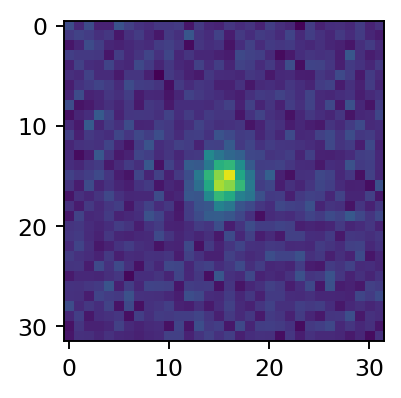

In [11]:
counts = 1000
SNR = 50.0
star, starData = makeStar(psf, counts, SNR, oneDpixels, True)

In [12]:
starData

{'author': 'Zeljko Ivezic',
 'muX': 0,
 'muY': 0,
 'sig2': 1.7,
 'sig1': 1.7,
 'alphaDeg': 0.0,
 'sigNoise': 3.3,
 'background': 0,
 'Counts': 1000,
 'CountsMeasured': 961.5265324006195,
 'CountsMeasuredErr': 19.886932207176184,
 'SNR': 48.34966612163808,
 'sigxxMeasured': 1.420284341514692,
 'sigxyMeasured': 0.006524995985593949,
 'sigyyMeasured': 1.4695736631315597,
 'sigP1Measured': 2.15994503035471,
 'sigP2Measured': 2.0169093317670224,
 'angleDegMeasured': -2.6173560031745557,
 'type': 'star'}

In [13]:
Npix, signal = getCountsInCircle(star, rPixSq, 2.7)
noise = np.sqrt(Npix)*starData['sigNoise']
snr = signal/noise
print(signal, snr)

695.8854597988515 43.044552927506125


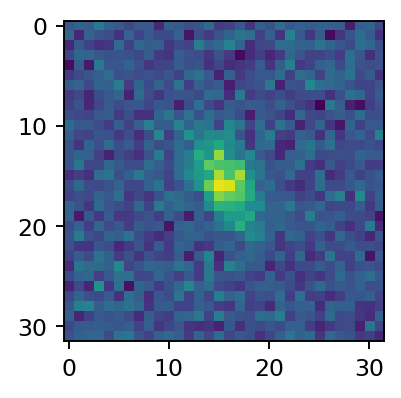

In [14]:
counts = 1000
SNR = 50.0
alphaDeg = 30
axisRatio = 2.0
trail, trailData = makeTrail(psf, counts, SNR, oneDpixels, alphaDeg, axisRatio, True)

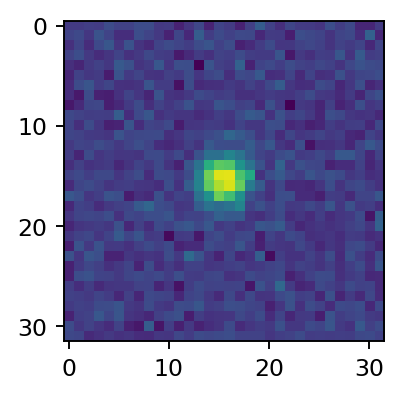

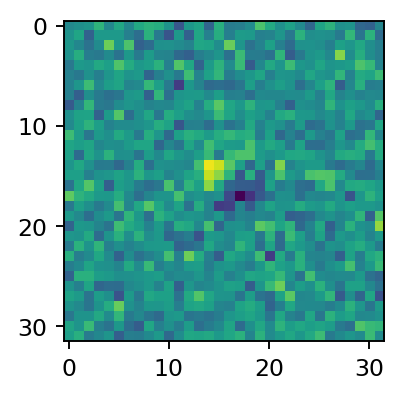

In [15]:
counts = 1000
SNR = 50.0
muX = -0.5
muY = 0.5
dipole, dipoleData = makeDipole(psf, counts, SNR, oneDpixels, muX, muY, True) 

In [16]:
psf, oneDpixels, psfData = makePSFstamp() 

## The SNR limit, output file name, etc. is set here... <a id='sample'></a>
[Go to top](#toc)

In [17]:
def cleanDir(fileroot):
    import glob
    # Get a list of all the file paths that ends with .txt from in specified directory
    fileList = glob.glob(fileroot + '*')
    # Iterate over the list of filepaths & remove each file.
    for filePath in fileList:
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)

In [18]:
stampDir = 'data/stampsResNet/'     # make this dir prior to running this code (for *fit files)
fileroot = stampDir + 'stamp_'
try:
    os.mkdir(stampDir)
    print("Created directory '% s'" % stampDir)
except FileExistsError:
    print("Directory '% s' already exists" % stampDir)
    print("Removing all '% s' files" % fileroot)
    cleanDir(fileroot)
else:
    print ('No exception occurred')

Directory 'data/stampsResNet/' already exists
Removing all 'data/stampsResNet/stamp_' files


In [19]:
### all good, now generate larger samples
kStamps = 10  # multiplicator for sizes below (total number of stamps is kStamps*300)
SNRmin = 20   # minimum signal-to-noise ratio 
npyFile = 'data/stamps4ResNetRerun.npy'      # alternative way to store stamps (used by ResNet50.ipynb)
# Lecture20.ipynb uses checked-in version named 'data/stamps4ResNet.npy' 

# defaults
FITS = False
Nstar0 = 100
Ntrail0 = 100
Ndipole0 = 100
Nstar = Nstar0*kStamps
Ntrail = Ntrail0*kStamps
Ndipole = Ndipole0*kStamps
Nstamps = kStamps*(Nstar0+Ntrail0+Ndipole0)
# make point spread function and pixel array
psf, oneDpixels, psfData = makePSFstamp()
Npixel = oneDpixels.size

# 3-D array to be stored in npy file (if FITS=False)
if FITS==False: 
    # stamps (pixel data) will be stored in npy file
    allArray = np.zeros((Nstamps,Npixel,Npixel,1))
else: 
    # stamps will be in FITS files, together with hdr data
    allArray = ""
    
counter = makeStars(psf, oneDpixels, 0, Nstar, fileroot, SNRmin, FITS, allArray)  
print('done with stars, counter:', counter)
counter = makeTrails(psf, oneDpixels, counter, Ntrail, fileroot, SNRmin, FITS, allArray)
print('done with trails, counter:', counter)
Ntotal = makeDipoles(psf, oneDpixels, counter, Ndipole, fileroot, SNRmin, FITS, allArray) 
print('done with all, counter:', Ntotal)

done with stars, counter: 1000
done with trails, counter: 2000
done with all, counter: 3000


In [20]:
# can tar them all using (in stamps dir): 
# tar -cvf all32pix-metadata.tar find . -name '.fits' -type f
if FITS==False: 
    np.save(npyFile, allArray, allow_pickle=False)
print('stamps are made! the rest of code is for testing purposes.')

stamps are made! the rest of code is for testing purposes.


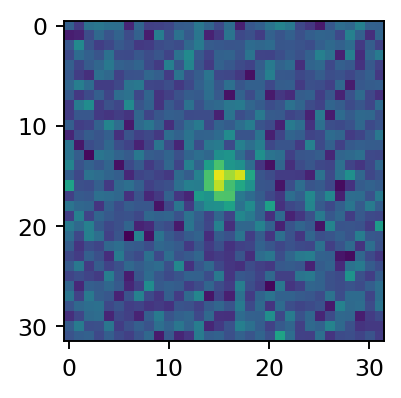

In [21]:
## test
iStamp = 619
s = fits.open(fileroot + str(iStamp) +'.fits')
if FITS==False: 
    pixData = np.load(npyFile)
    s[0].data = pixData[iStamp,0:32,0:32,0]
showStamp(s[0].data)

In [22]:
# more tests: compute and plot a few obvious quantities
labels, SNR, CountsM, tE, mE, sigP1, aDeg, aDegM = getStampData(fileroot, 0, Nstamps-1)

In [23]:
for L in ['star', 'trail', 'dipole']:
    t = mE[labels==L]
    aD = aDeg[labels==L]
    aM = aDegM[labels==L]
    C = CountsM[labels==L]
    print(L, 'CM, mean=', np.mean(C), ' std=', np.std(C), ' max=', np.max(C))    
    print(L, 'mE, mean=', np.mean(t), ' std=', np.std(t), ' max=',  np.max(t))
    print(L, 'aD, mean=', np.mean(aD), ' std=', np.std(aD), ' max=',  np.max(aD))
    print(L, 'aM, mean=', np.mean(aM), ' std=', np.std(aM), ' max=',  np.max(aM))    

star CM, mean= 1000.4286409309793  std= 32.61967914187076  max= 1119.179227704537
star mE, mean= 1.1106821477043471  std= 0.10079386187578823  max= 1.8582198665146656
star aD, mean= 0.0  std= 0.0  max= 0.0
star aM, mean= 0.3986668343471552  std= 18.01752775953585  max= 44.70512926294259
trail CM, mean= 761.0307235303638  std= 100.95843632117094  max= 1027.984476710161
trail mE, mean= 1.6768207653900602  std= 0.45133362208246564  max= 3.775713753427651
trail aD, mean= 88.46491310280203  std= 51.70956973798566  max= 179.5399094744465
trail aM, mean= -0.14972610239571738  std= 16.50587157701936  max= 44.57386565622748
dipole CM, mean= 13.432354673913396  std= 45.24001279359793  max= 168.0388026564905
dipole mE, mean= -68.21198814379997  std= 2601.417463282516  max= 17671.57227471952
dipole aD, mean= 0.0  std= 0.0  max= 0.0
dipole aM, mean= -0.9580487565245158  std= 20.038873054303185  max= 44.82020882485183


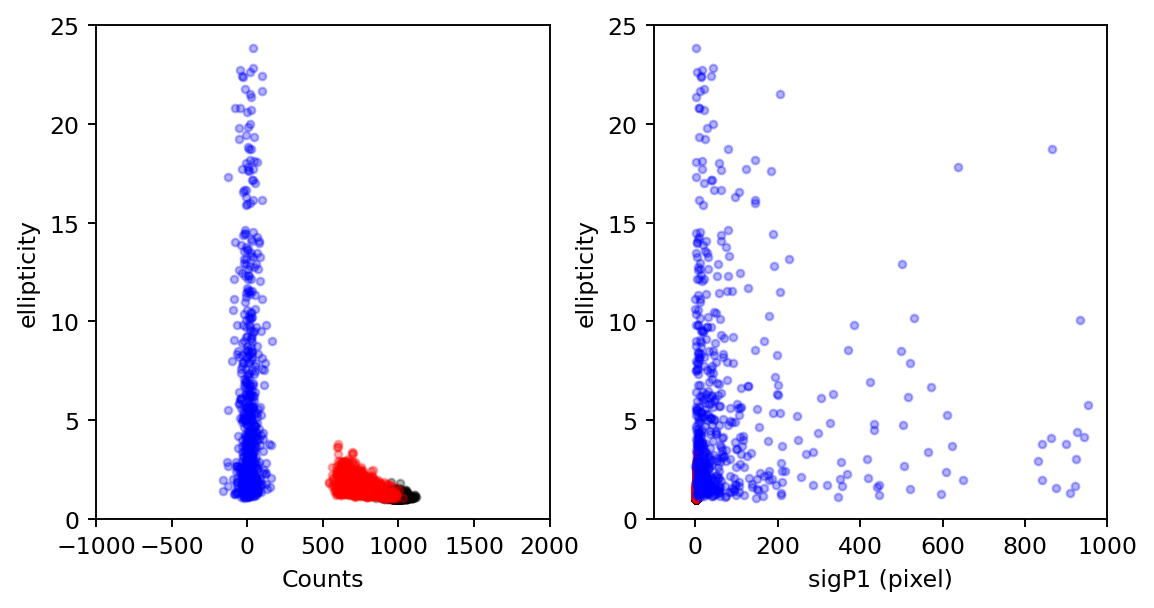

In [24]:
fig = plt.figure(figsize=(7, 3.5))
fig.subplots_adjust(wspace=0.23, hspace=0.28, left=0.1,
                        right=0.95, bottom=0.12, top=0.95)

def plotOneType(axis, x, y, labels, L, color):
    xT = x[labels==L]
    yT = y[labels==L]
    axis.scatter(xT, yT, s=10, c=color, alpha=0.3)

ax = plt.subplot(121)
plotOneType(ax, CountsM, mE, labels, 'star', 'black')
plotOneType(ax, CountsM, mE, labels, 'trail', 'red')
plotOneType(ax, CountsM, mE, labels, 'dipole', 'blue')
ax.set_xlim(-1000, 2000)
ax.set_ylim(0, 25)
ax.set_xlabel('Counts')
ax.set_ylabel('ellipticity')


ax = plt.subplot(122)
plotOneType(ax, sigP1, mE, labels, 'star', 'black')
plotOneType(ax, sigP1, mE, labels, 'trail', 'red')
plotOneType(ax, sigP1, mE, labels, 'dipole', 'blue')
ax.set_xlim(-100, 1000)
ax.set_ylim(0, 25)
ax.set_xlabel('sigP1 (pixel)')
ax.set_ylabel('ellipticity')


plt.show()

### Now run ResNet50  (see ResNet50.ipynb notebook)...